## Create a VM instance

In [ ]:
from chi import server, context
import chi, os, time, datetime

context.version = "1.0" 
context.choose_project()
context.choose_site(default="KVM@TACC")

In [ ]:
username = os.getenv('USER') # all exp resources will have this prefix
s = server.Server(
    f"node-data-pipeline-project32", 
    image_name="CC-Ubuntu24.04",
    flavor_name="m1.large"
)
s.submit(idempotent=True)

In [ ]:
s.associate_floating_ip()

In [ ]:
s.refresh()
s.check_connectivity()

In [ ]:
security_groups = [
  {'name': "allow-ssh", 'port': 22, 'description': "Enable SSH traffic on TCP port 22"},
  {'name': "allow-8888", 'port': 8888, 'description': "Enable TCP port 8888 (used by Jupyter)"},
  {'name': "allow-8000", 'port': 8000, 'description': "Enable TCP port 8000 (used by MLFlow)"},
  {'name': "allow-9000", 'port': 9000, 'description': "Enable TCP port 9000 (used by MinIO API)"},
  {'name': "allow-9001", 'port': 9001, 'description': "Enable TCP port 9001 (used by MinIO Web UI)"}
]

In [ ]:
# configure openstacksdk for actions unsupported by python-chi
os_conn = chi.clients.connection()
nova_server = chi.nova().servers.get(s.id)

for sg in security_groups:

  if not os_conn.get_security_group(sg['name']):
      os_conn.create_security_group(sg['name'], sg['description'])
      os_conn.create_security_group_rule(sg['name'], port_range_min=sg['port'], port_range_max=sg['port'], protocol='tcp', remote_ip_prefix='0.0.0.0/0')

  nova_server.add_security_group(sg['name'])

print(f"updated security groups: {[group.name for group in nova_server.list_security_group()]}")

In [ ]:
s.execute("git clone https://github.com/BugBeak/MLOps/tree/main/data_pipeline")

In [ ]:
s.execute("export GITHUB_TOKEN=\"your_actual_token\"")

## Provision an object store


1) Go to Horizon GUI and click on “Object Store” > “Containers” and then, “Create Container”
2) Specify the name as object-persist-group32 on the wizard and submit!

## Setup Docker

In [ ]:
s.execute("curl -sSL https://get.docker.com/ | sudo sh")
s.execute("sudo groupadd -f docker; sudo usermod -aG docker $USER")

## Open an SSH session
Finally, open an SSH sesson on your server. From your local terminal, run

ssh -i ~/.ssh/id_rsa_chameleon cc@A.B.C.D

## Setting up rclone

In [ ]:
sudo sed -i '/^#user_allow_other/s/^#//' /etc/fuse.conf

mkdir -p ~/.config/rclone
nano  ~/.config/rclone/rclone.conf

[chi_tacc]
type = swift
user_id = YOUR_USER_ID
application_credential_id = APP_CRED_ID
application_credential_secret = APP_CRED_SECRET
auth = https://chi.tacc.chameleoncloud.org:5000/v3
region = CHI@TACC

## Building the docker image

In [ ]:
s.execute("cd ~/data_pipeline")

# Build data pipeline docker image
s.execute("docker compose build")

## The data pipeline runs on three modes:
1. remote
2. local
3. online


In [ ]:
s.execute("docker compose run --rm pipeline python run_pipeline.py --config /app/config.yaml --intermediate-dir /app/pipeline_intermediate")

## local mode
s.execute("docker compose run --rm pipeline python run_pipeline.py --config /app/config.yaml --intermediate-dir /app/pipeline_intermediate  --local")

## debug mode
s.execute("docker compose run --rm pipeline python run_pipeline.py --config /app/config.yaml --intermediate-dir /app/pipeline_intermediate  --debug")

## Online Evaluation mode

To run the data-pipeline in online evaluation mode (with the ability to ingest a new unseen Github Pull Request), build a new online-evaluator container and run it with the PR of your choice.


In [ ]:
s.execute("docker compose build online-evaluator")

In [ ]:
s.execute("docker compose run --rm online-evaluator --pr-identifier \"https://github.com/jenkinsci/git-plugin/pull/967\"")

## Dashboard
Here are the steps to run the streamlit.io dashboard 

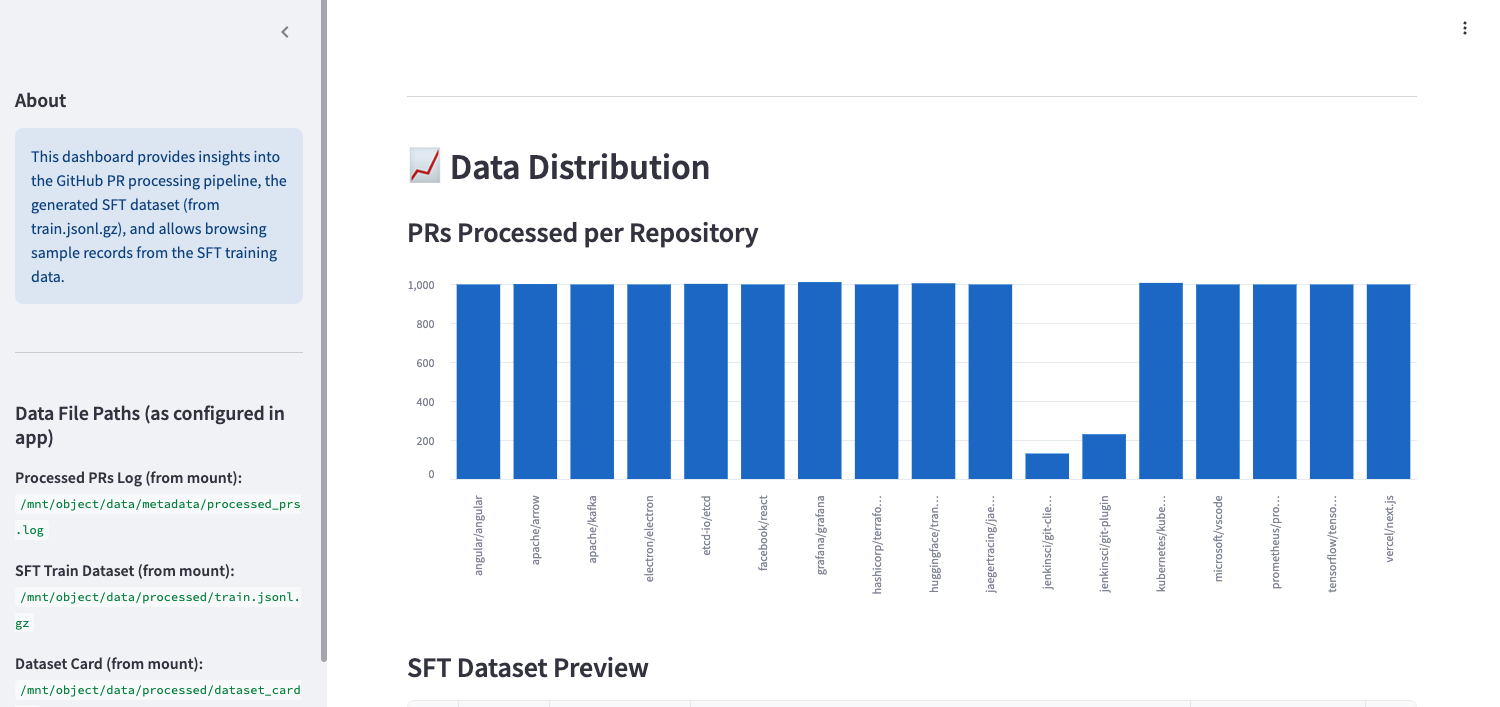

In [ ]:
# Build the docker image
s.execute("docker build -t dashboard-app -f dashboard.Dockerfile .")

In [ ]:
# Run the docker container
s.execute("docker run -p 8888:8888 dashboard-app")

In [ ]:
dashboard_url= "http://" + s.associate_floating_ip() + ":8888/"